In [235]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [236]:
data_loc = "D:/Beam Characterization/2019_3_12/"
fname = "2019_03_12_new.hdf"

In [237]:
with h5py.File(data_loc+fname, 'r') as f:
    for name in f.keys():
        print(name)

1552437381 checking UV power effect
1552439007 6.25Hz ablation
1552439349 new spot 1
1552439408 6.25Hz ablation decay 2
1552439801 new spot 2
1552439879 6.25Hz ablation decay 3


In [238]:
run_name = "/1552437381 checking UV power effect"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['Bristol671A'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

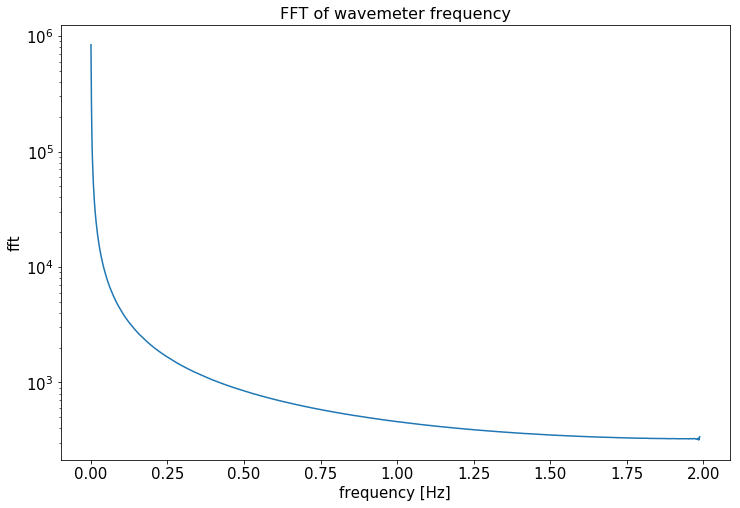

In [239]:
start, stop = 0, -1
p = np.abs(np.fft.rfft(wavemeter[start:stop,0]))
f = np.fft.rfftfreq(wavemeter[start:stop,0].size, np.mean(np.diff(wavemeter[start:stop,0])))
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(f,p)
ax.set_yscale('log')
ax.set_xlabel('frequency [Hz]', fontsize = 15)
ax.set_ylabel('fft', fontsize = 15)
ax.set_title('FFT of wavemeter frequency', fontsize = 16);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

In [240]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

Oskari unplugged the yag photodiode at some point so I can't quickly scan for which datasets the yag fired

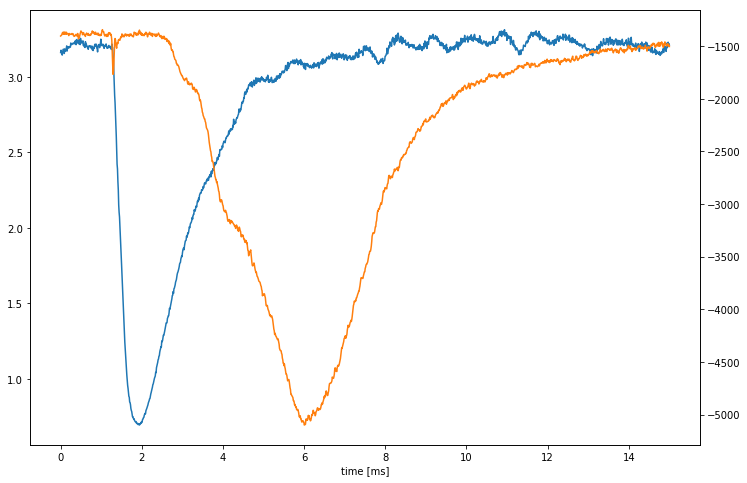

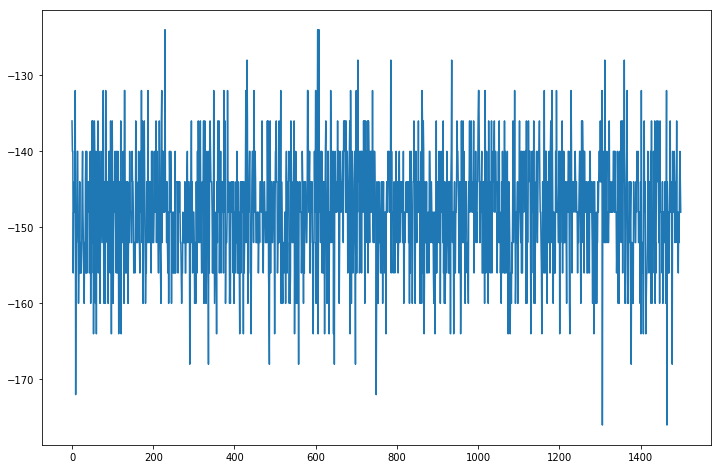

In [241]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

rate = 1/6.25
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

idx = 300

x = np.linspace(0,1500,1500)/100

data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')

ax.set_xlabel("time [ms]")

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(data_p)

In [242]:
import tqdm
integrals = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(range(1,len(fast_daq))):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 5e2:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[:100], dx=dx)
        signal = np.trapz(data_f[200:1500], dx=dx)-13*background
        integrals.append((idx,signal*-1,background*-1))
integrals = np.array(integrals)

100%|███████████████████████████████████████████████████████████████████████████| 1299/1299 [00:00<00:00, 18040.82it/s]


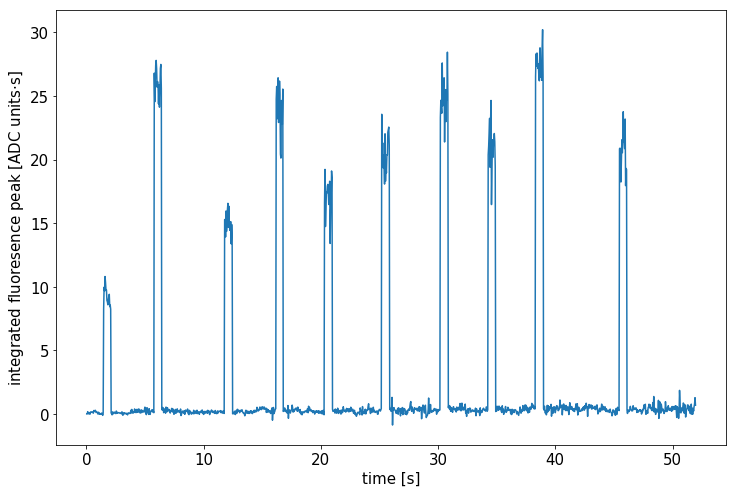

In [243]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(integrals[:,0]*1/25, integrals[:,1])
ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('integrated fluoresence peak [ADC units$\cdot$s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

In [244]:
def cluster(data, maxgap):
    '''Arrange data into groups where successive elements
       differ by no more than *maxgap*

        >>> cluster([1, 6, 9, 100, 102, 105, 109, 134, 139], maxgap=10)
        [[1, 6, 9], [100, 102, 105, 109], [134, 139]]

        >>> cluster([1, 6, 9, 99, 100, 102, 105, 134, 139, 141], maxgap=10)
        [[1, 6, 9], [99, 100, 102, 105], [134, 139, 141]]

    '''
    data.sort()
    groups = [[data[0]]]
    for x in data[1:]:
        if abs(x - groups[-1][-1]) <= maxgap:
            groups[-1].append(x)
        else:
            groups.append([x])
    return groups

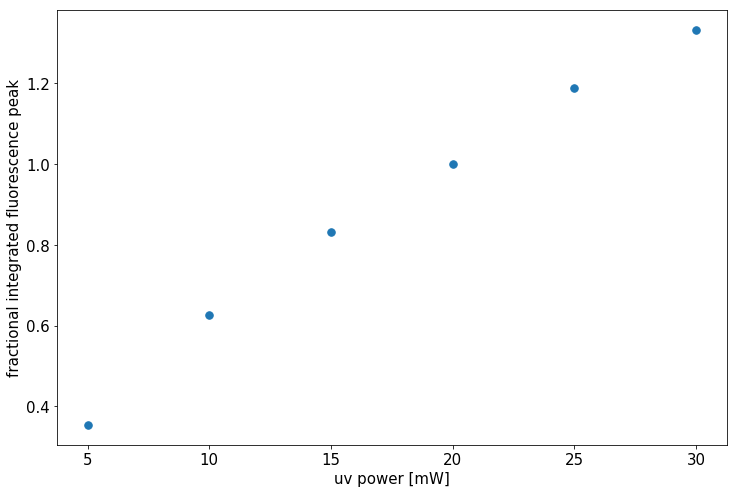

In [245]:
grouped = cluster(np.where(integrals[:,1] > 5)[0], 5)
uv_power = [5, 20, 10, 20, 15, 20, 25, 20, 30, 20]

means = []
for g in grouped:
    means.append(np.mean(integrals[:,1][np.array(g)]))
means = np.array(means)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(uv_power[::2], means[:-1:2]/means[1::2], '.', ms = 15)
ax.plot(20, 1, 'C0.', ms = 15)
ax.set_xlabel('uv power [mW]', fontsize = 15)
ax.set_ylabel('fractional integrated fluorescence peak', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
fig.savefig('uv_power_scan.png')

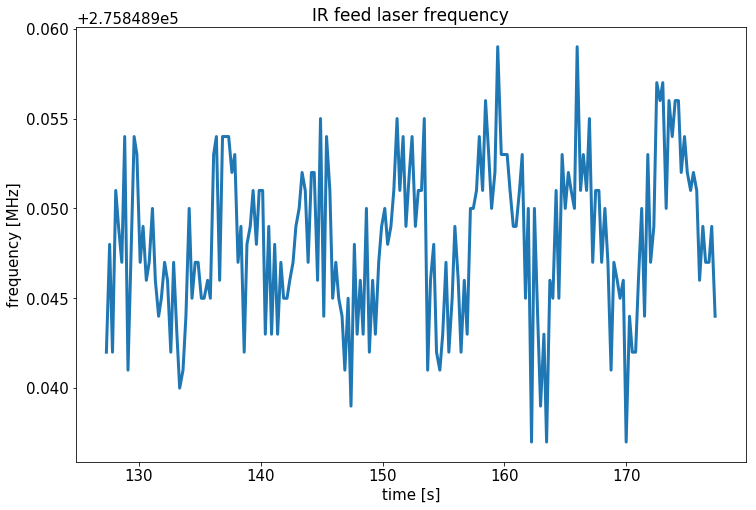

In [246]:
start, stop = 500, 700
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[start:stop,0], wavemeter[start:stop,1]*1e3, lw = 3)
ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('frequency [MHz]', fontsize = 15)
ax.set_title('IR feed laser frequency', fontsize = 17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.yaxis.get_offset_text().set_size(15)

In [247]:
run_name = '1552439408 6.25Hz ablation decay 2'
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['Bristol671A'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

In [248]:
import tqdm
integrals = []
peak_pos = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(range(1,len(fast_daq))):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 5e2:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[:100], dx=dx)
        signal = np.trapz(data_f[200:1500], dx=dx)-13*background
        integrals.append((idx,signal*-1,background*-1))
        peak_pos.append((idx,(np.argmin(data_f[200:1500])+100)/100))
integrals = np.array(integrals)
peak_pos = np.array(peak_pos)

100%|███████████████████████████████████████████████████████████████████████████| 2361/2361 [00:00<00:00, 16279.09it/s]


In [249]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

rate = 1/6.25
wavelength_values = []
for idx in range(1,len(fast_daq)):
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

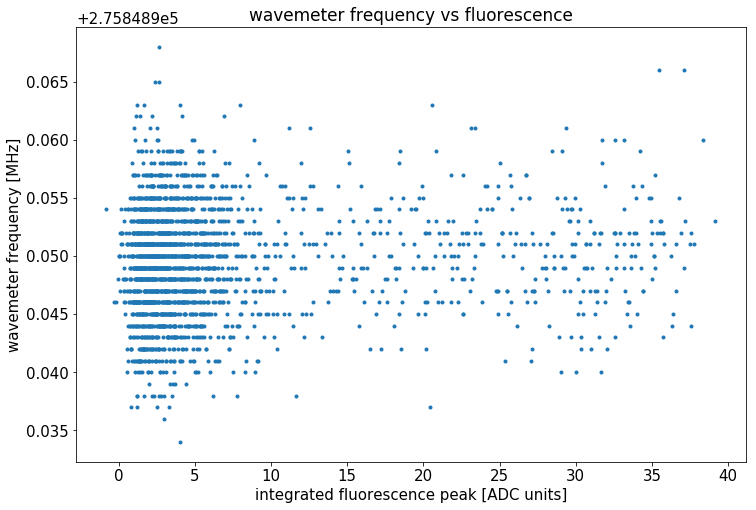

In [250]:
start, stop = 46,-1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(integrals[start:stop,1], wavelength_values[start:stop,1]*1e3, '.')
ax.set_xlabel('integrated fluorescence peak [ADC units]', fontsize = 15)
ax.set_title('wavemeter frequency vs fluorescence', fontsize = 17)
ax.set_ylabel('wavemeter frequency [MHz]', fontsize =15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.yaxis.get_offset_text().set_size(15)

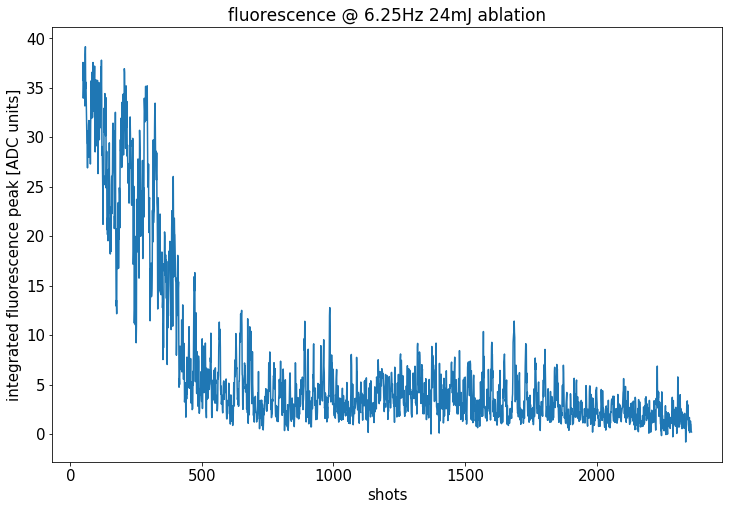

In [251]:
start = 46
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(integrals[start:,0], integrals[start:,1])
ax.set_xlabel('shots', fontsize = 15)
ax.set_ylabel('integrated fluorescence peak [ADC units]', fontsize = 15)
ax.set_title('fluorescence @ 6.25Hz 24mJ ablation', fontsize = 17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.yaxis.get_offset_text().set_size(15)
fig.savefig("fluorescence_6.25Hzablation.png")

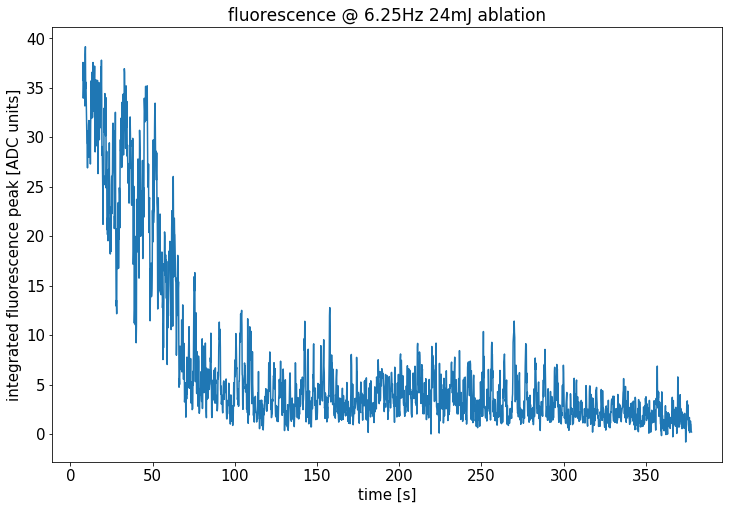

In [252]:
start = 46
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(integrals[start:,0]/6.25, integrals[start:,1])
ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('integrated fluorescence peak [ADC units]', fontsize = 15)
ax.set_title('fluorescence @ 6.25Hz 24mJ ablation', fontsize = 17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.yaxis.get_offset_text().set_size(15)

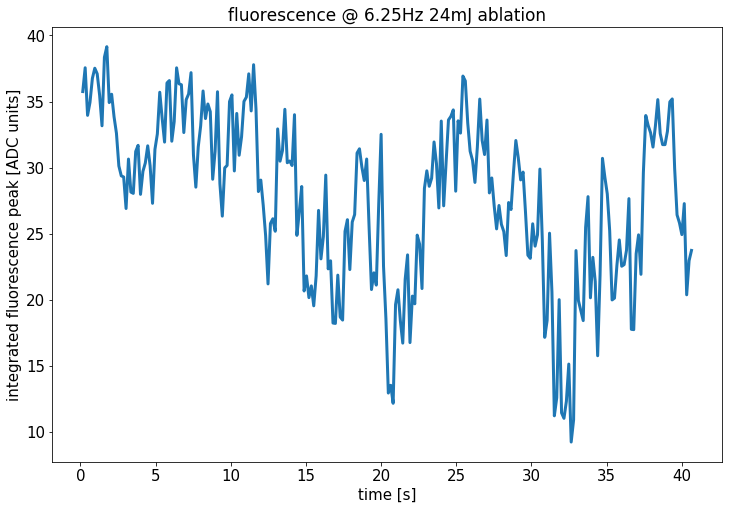

In [253]:
start, stop = 46,300
fig, ax = plt.subplots(figsize = (12,8))
ax.plot((integrals[start:stop,0]-start)/6.25, integrals[start:stop,1], lw = 3)
ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('integrated fluorescence peak [ADC units]', fontsize = 15)
ax.set_title('fluorescence @ 6.25Hz 24mJ ablation', fontsize = 17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.yaxis.get_offset_text().set_size(15)
fig.savefig('fluorescence_integrated_peak.png')

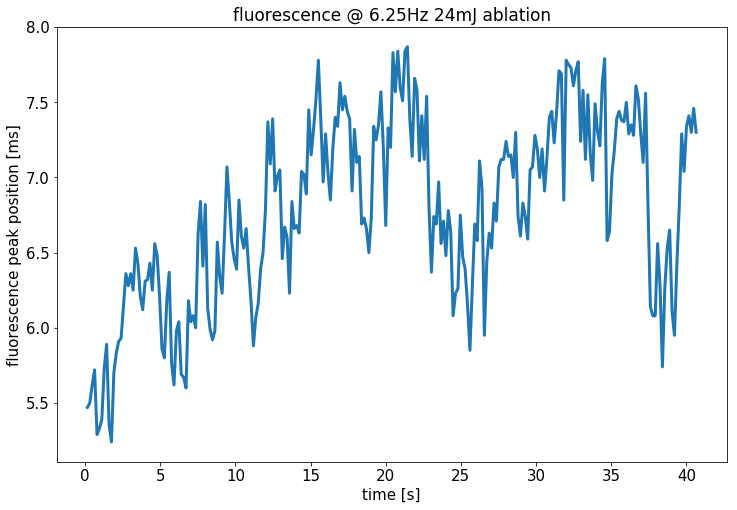

In [254]:
start, stop = 46,300
fig, ax = plt.subplots(figsize = (12,8))
ax.plot((peak_pos[start:stop,0]-start)/6.25, peak_pos[start:stop,1], lw = 3)
ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('fluorescence peak position [ms]', fontsize = 15)
ax.set_title('fluorescence @ 6.25Hz 24mJ ablation', fontsize = 17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.yaxis.get_offset_text().set_size(15)
fig.savefig('fluorescence_peak_position.png')

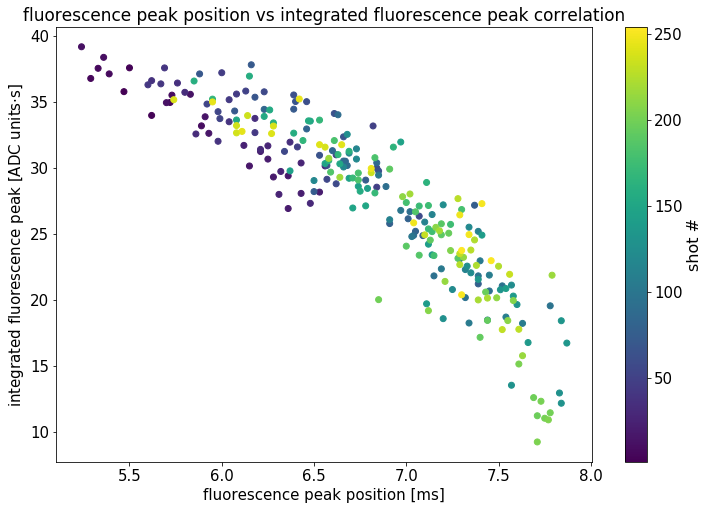

In [256]:
start, stop = 46, 300

fig, ax = plt.subplots(figsize = (12,8))
cax = ax.scatter(peak_pos[start:stop,1], integrals[start:stop, 1], c=peak_pos[start:stop,0]-start)
cbar = fig.colorbar(cax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_ylabel('shot #', fontsize = 16)

ax.set_xlabel('fluorescence peak position [ms]', fontsize = 15)
ax.set_ylabel('integrated fluorescence peak [ADC units$\cdot$s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.yaxis.get_offset_text().set_size(15)
ax.set_title('fluorescence peak position vs integrated fluorescence peak correlation', fontsize = 17);
fig.savefig('integratedpeak_peakpos_correlation.png')

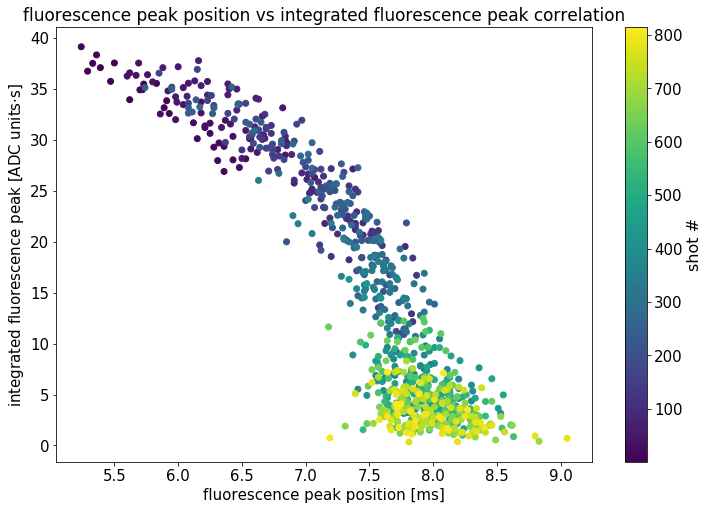

In [257]:
start, stop = 46, -1500

fig, ax = plt.subplots(figsize = (12,8))
cax = ax.scatter(peak_pos[start:stop,1], integrals[start:stop, 1], c=peak_pos[start:stop,0]-start)
cbar = fig.colorbar(cax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_ylabel('shot #', fontsize = 16)

ax.set_xlabel('fluorescence peak position [ms]', fontsize = 15)
ax.set_ylabel('integrated fluorescence peak [ADC units$\cdot$s]', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.yaxis.get_offset_text().set_size(15)
ax.set_title('fluorescence peak position vs integrated fluorescence peak correlation', fontsize = 17);
fig.savefig('integratedpeak_peakpos_correlation_more.png')

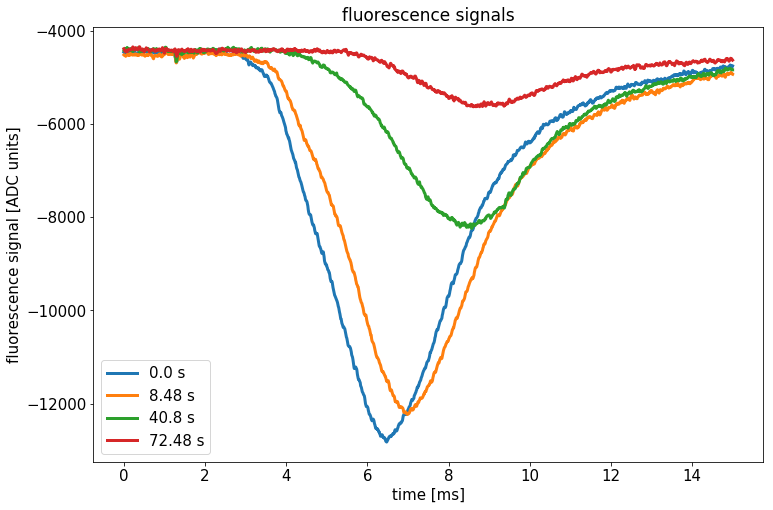

In [258]:
x = np.linspace(0,1500,1500)/100

fig, ax = plt.subplots(figsize = (12,8))
for idx in [47,100,302,500]:
    data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
    data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]

    ax.plot(x, data_f, lw = 3, label = '{0} s'.format((idx-47)/6.25))

ax.set_xlabel("time [ms]", fontsize = 15)
ax.set_ylabel('fluorescence signal [ADC units]', fontsize = 15)
ax.set_title('fluorescence signals', fontsize = 17)
ax.legend(fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.yaxis.get_offset_text().set_size(15)
fig.savefig('fluorescence_signals.png')